In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib
import fsspec
from helper import calc_local_roughness

# import fancy plotting
import json
plt.rcParams.update(json.load(open("../plot_settings.json")))

In [3]:
ds = xr.open_dataset('../../data/training.nc')
correction_fields = xr.open_dataset('../../data/correction_fields.nc')

### correct the BT_2D for each day with the corresponding correction field

for timestep in ds.time:
    date = timestep.dt.strftime('%Y-%m-%d')
    # select the correction field for the specific date
    cf = correction_fields.BT_2D.sel(time=date)

    # select the BT_2D for the specific date
    bt = ds.BT_2D.sel(time=timestep).values

    # correct the BT_2D
    bt_corrected = bt - cf

    # replace the BT_2D with the corrected values
    ds.BT_2D.loc[dict(time=timestep, band=[1, 2, 3, 4])] = bt_corrected.isel(band=[1, 2, 3, 4])


ds_new = calc_local_roughness(ds)


ds_new_flat = ds_new.stack(z=('x', 'y', 'time'))
ds_new_flat = ds_new_flat.chunk({'z' : 100_000})


In [4]:
X1 = ds_new_flat.isel(band=0)['BT_2D']
X2 = ds_new_flat.isel(band=1)['BT_2D'] - ds_new_flat.isel(band=3)['BT_2D']
X3 = ds_new_flat.isel(band=2)['BT_2D'] - ds_new_flat.isel(band=3)['BT_2D']
X4 = ds_new_flat.isel(band=3)['BT_2D'] - ds_new_flat.isel(band=4)['BT_2D']
X5 = ds_new_flat.isel(band=2)['BT_2D'] - ds_new_flat.isel(band=4)['BT_2D']

X6 = ds_new_flat['sur_rgh']
X7 = ds_new_flat['neighbor_mean']
X8 = ds_new_flat['neighbor_std']

group = ds_new_flat.time.dt.dayofyear
y = ds_new_flat['label']
sample = ds_new_flat['time']


In [5]:
ds_training = xr.Dataset(
    data_vars=dict(
        y=(['z'],   y.values),
        X1=(['z'], X1.values),
        X2=(['z'], X2.values),
        X3=(['z'], X3.values),
        X4=(['z'], X4.values),
        X5=(['z'], X5.values),
        X6=(['z'], X6.values),
        X7=(['z'], X7.values),
        X8=(['z'], X8.values),
        group=(['z'], group.values),
        sample=(['z'], sample.values),
    ),
    coords=dict(
        z=np.arange(len(ds_new_flat.z)),
    ),
)

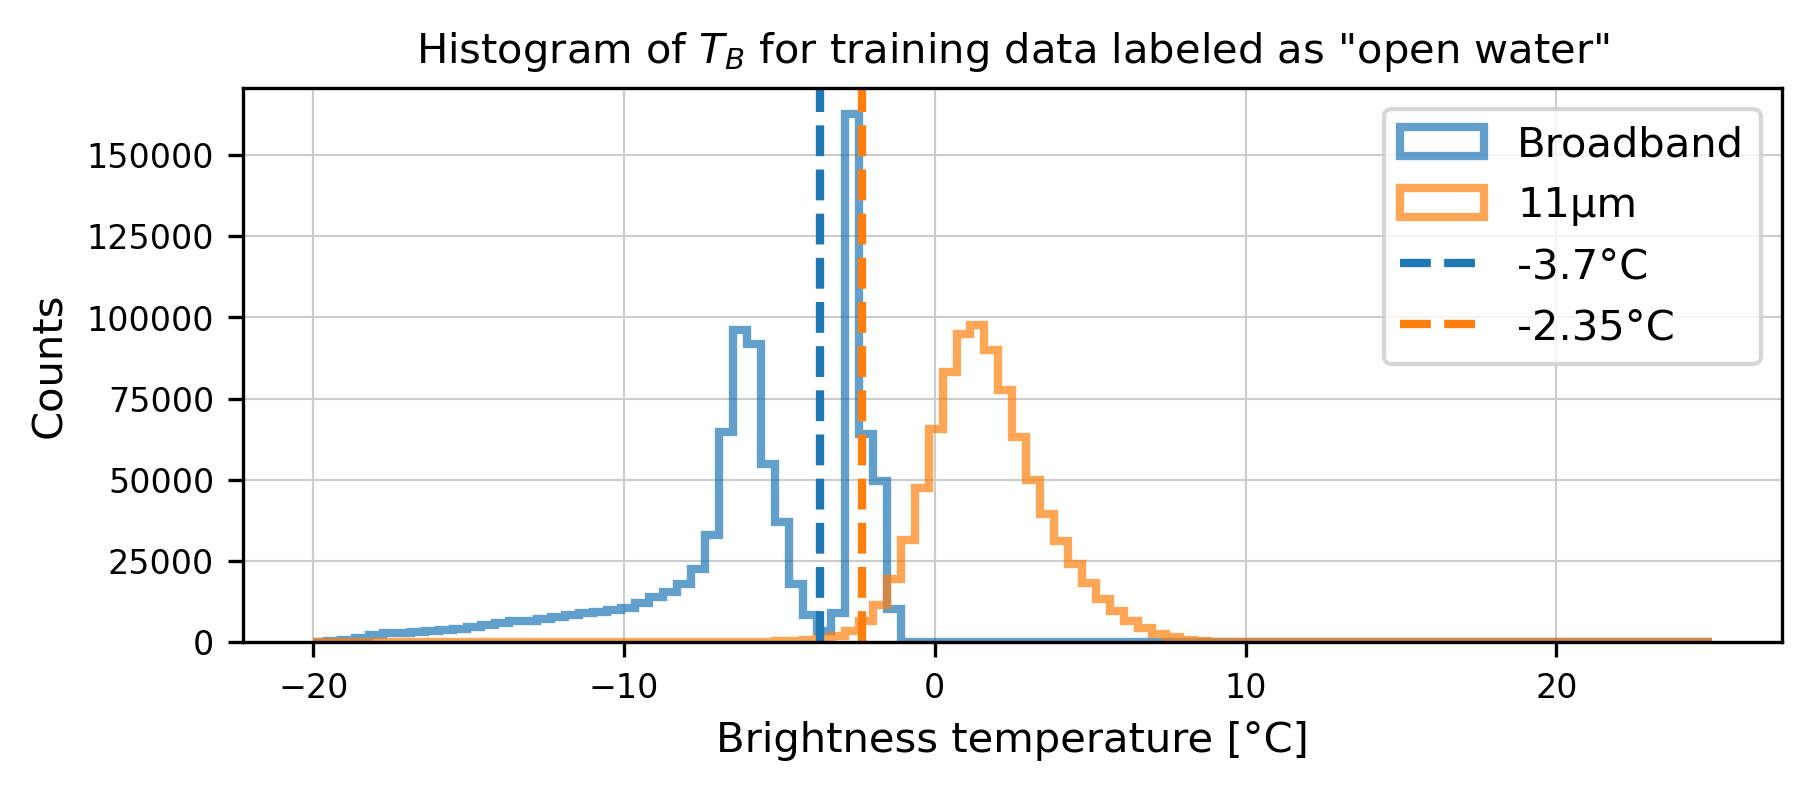

In [6]:
ds_training.X1.where(ds_training.y == 1).plot.hist(bins=100, alpha=.7, label='Broadband', range=(-20,25), histtype='step', lw=2)
ds_training.X5.where(ds_training.y == 1).plot.hist(bins=100, alpha=.7, label='11µm', range=(-20,25), histtype='step', lw=2)

plt.axvline(-3.7, color='C0', linestyle='--', label='-3.7°C')
plt.axvline(-2.35, color='C1', linestyle='--', label='-2.35°C')

plt.title('Histogram of $T_B$ for training data labeled as "open water"')
plt.xlabel('Brightness temperature [°C]')
plt.ylabel('Counts')

plt.legend()
plt.show()


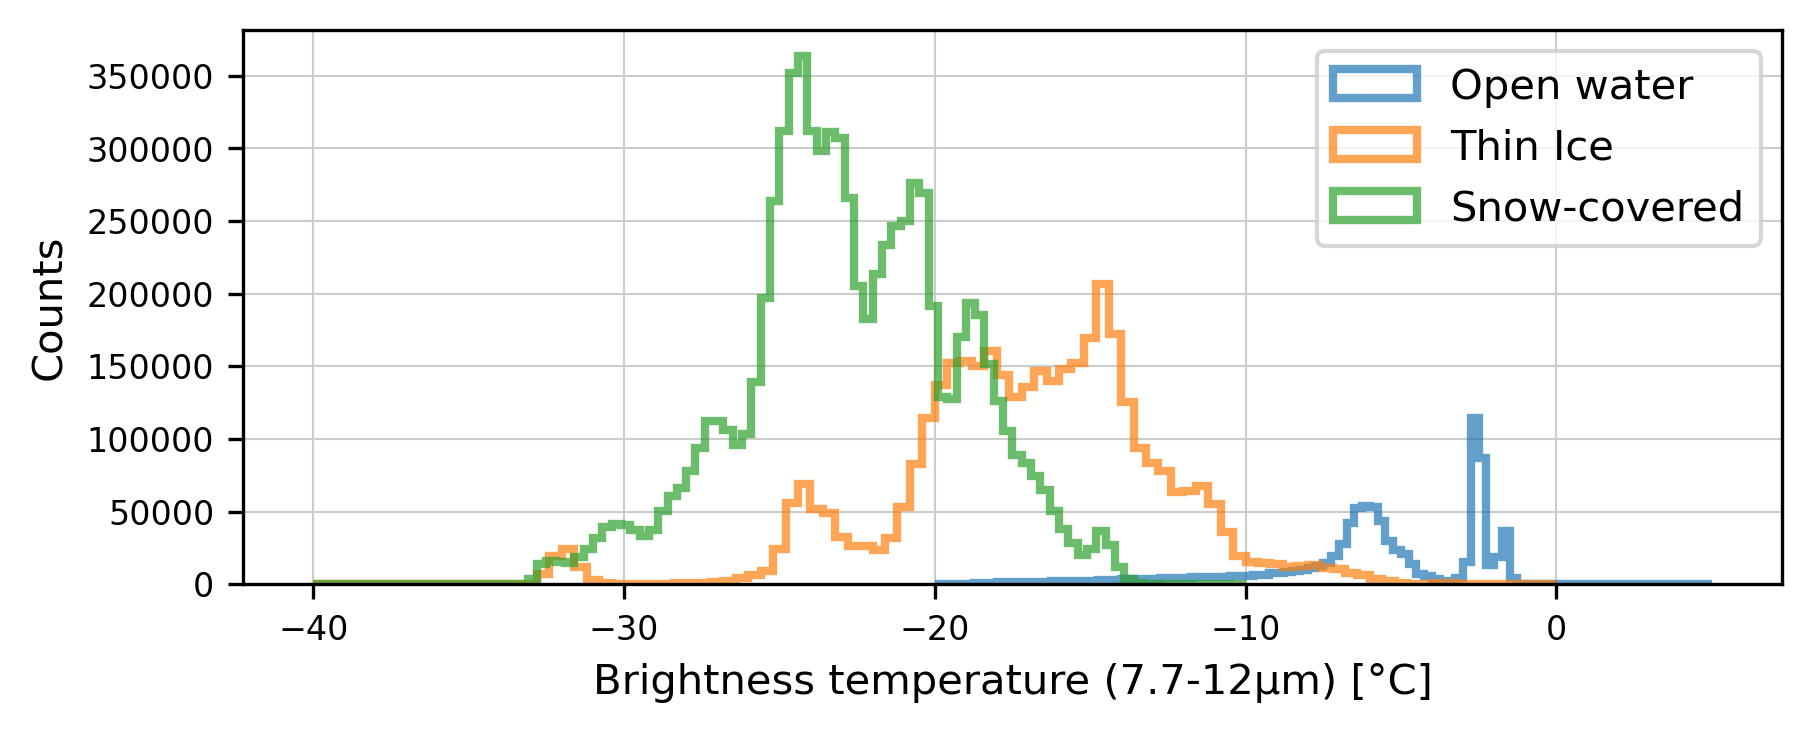

In [7]:
ds_training['X1'].where(ds_training.y == 1).plot.hist(bins=100, alpha=.7, label='Open water', range=(-20,5), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y == 2).plot.hist(bins=100, alpha=.7, label='Thin Ice', range=(-40, 0), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y == 4).plot.hist(bins=100, alpha=.7, label='Snow-covered', range=(-40, -10), histtype='step', lw=2)
plt.legend()
plt.xlabel('Brightness temperature (7.7-12µm) [°C]')
plt.ylabel('Counts')
plt.show()

In [8]:

ds_training['y'] = xr.where(ds_training.y == 0, np.nan, ds_training['y'])
ds_training['y'] = xr.where(ds_training.y == 3, np.nan, ds_training['y'])
#ds_training = ds_training.dropna(dim='z', how='any')

ds_training.to_netcdf('../../data/training_flat.nc', mode='w')
ds_training = xr.open_dataset('../../data/training_flat.nc', chunks={'z': 1_000_000})


In [9]:
ds_training['y_corrected'] = ds_training.y
ds_training['y_corrected'] = xr.where((ds_training.X1 < -3.7) & (ds_training.X1 > -10) & (ds_training.y == 1), 4, ds_training.y_corrected)
ds_training['y_corrected'] = xr.where((ds_training.X1 < -10) & (ds_training.y == 1), 2, ds_training.y_corrected)
ds_training['y_corrected'] = xr.where(ds_training.y == 4, 3, ds_training.y_corrected)
ds_training['y_corrected'] = xr.where((ds_training.X1 < -27) & (ds_training.y == 2), 3, ds_training.y_corrected)

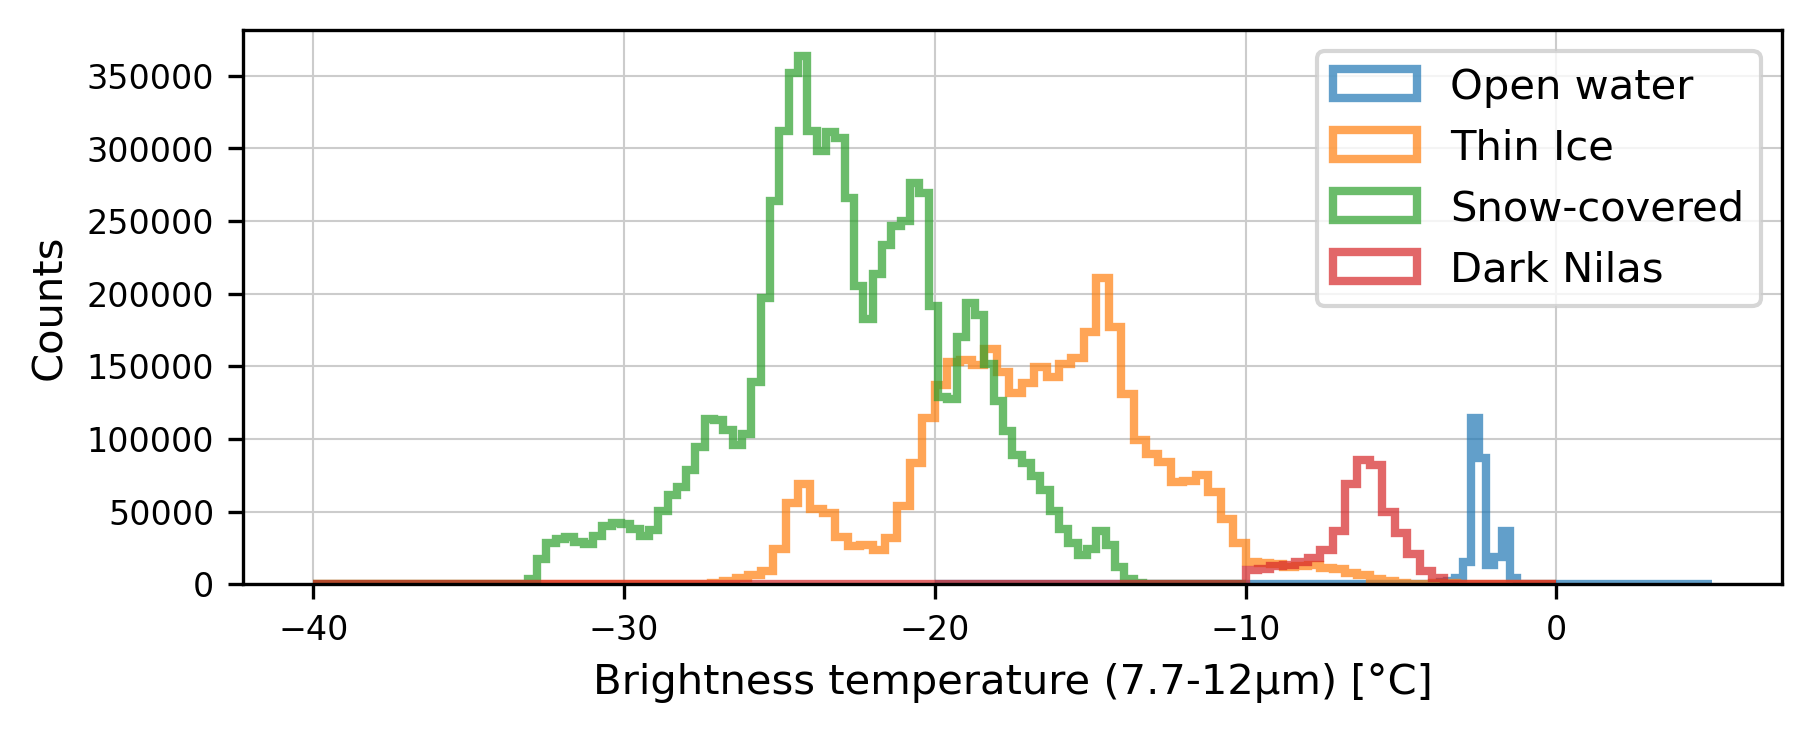

In [10]:
ds_training['X1'].where(ds_training.y_corrected == 1).plot.hist(bins=100, alpha=.7, label='Open water', range=(-20,5), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y_corrected == 2).plot.hist(bins=100, alpha=.7, label='Thin Ice', range=(-40, 0), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y_corrected == 3).plot.hist(bins=100, alpha=.7, label='Snow-covered', range=(-40, -10), histtype='step', lw=2)
ds_training['X1'].where(ds_training.y_corrected == 4).plot.hist(bins=100, alpha=.7, label='Dark Nilas', range=(-40, 0), histtype='step', lw=2)
plt.legend()
plt.xlabel('Brightness temperature (7.7-12µm) [°C]')
plt.ylabel('Counts')
plt.show()

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 6.10000e+01, 3.57400e+03, 2.63280e+04, 3.98860e+04,
        4.37490e+04, 3.84100e+04, 4.04090e+04, 5.29920e+04, 5.71800e+04,
        5.78780e+04, 5.46000e+04, 6.53820e+04, 9.83200e+04, 1.29810e+05,
        1.68792e+05, 2.14643e+05, 2.29036e+05, 2.18932e+05, 2.13445e+05,
        2.69655e+05, 3.89896e+05, 5.22793e+05, 6.44344e+05, 6.86283e+05,
        6.02775e+05, 6.35691e+05, 6.69706e+05, 5.99531e+05, 5.53308e+05,
        6.47531e+05, 7.73764e+05, 8.62454e+05, 9.76889e+05, 9.21595e+05,
        7.41547e+05, 6.71320e+05, 7.04005e+05, 6.77379e+05, 5.74111e+05,
        4.74144e+05, 3.80954e+05, 3.42448e+05, 3.47512e+05, 3.03993e+05,
        2.72627e+05, 2.50654e+05, 2.82517e+05, 3.60631e+05, 3.11930e+05,
        1.98156e+05, 1.41726e+05, 1.24257e+05, 1.15

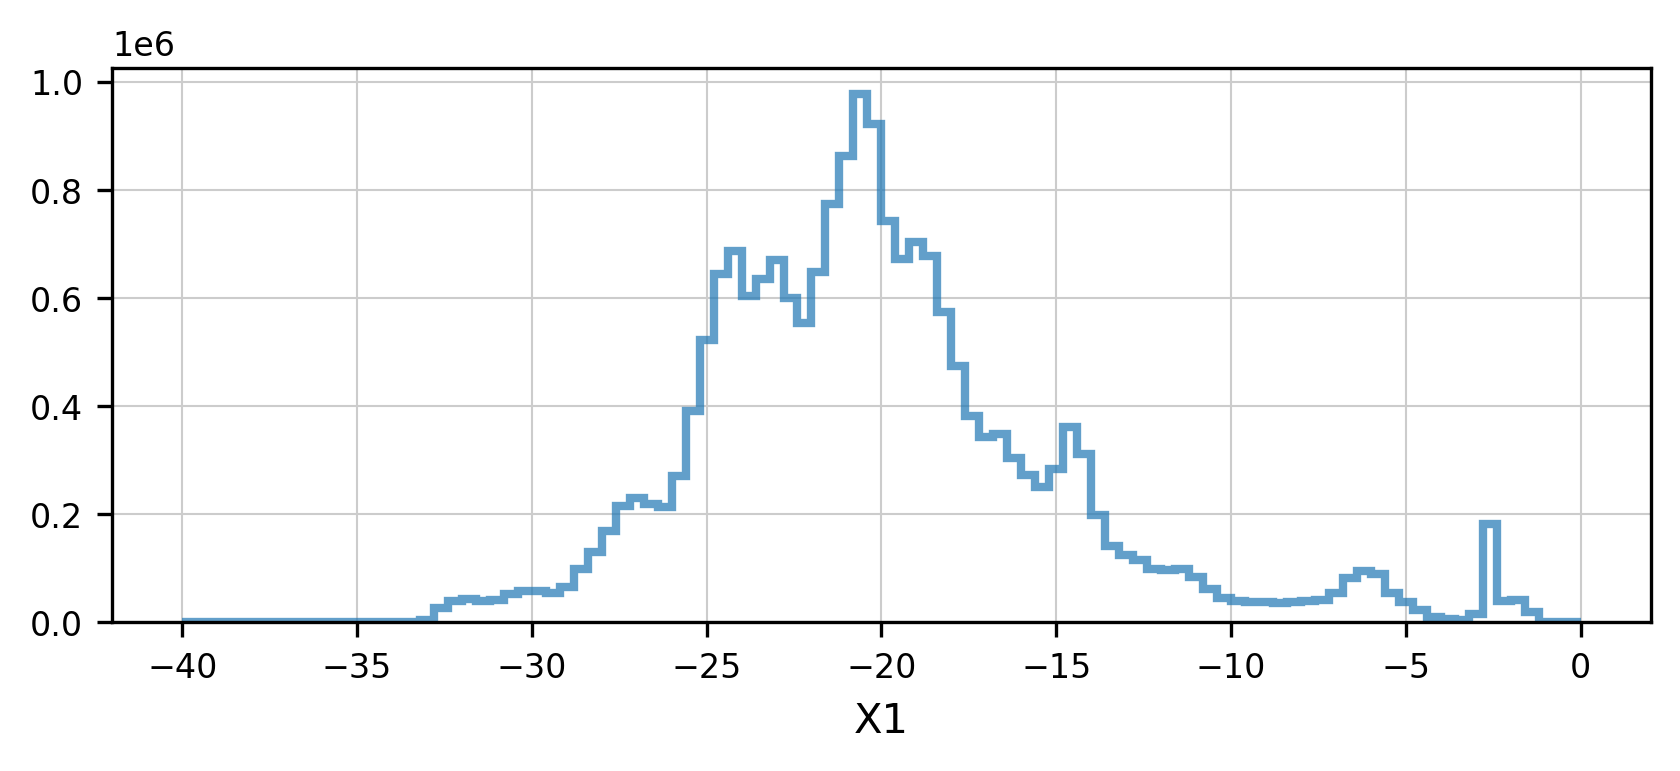

In [11]:
ds_training['X1'].plot.hist(bins=100, alpha=.7, label='All', range=(-40, 0), histtype='step', lw=2)

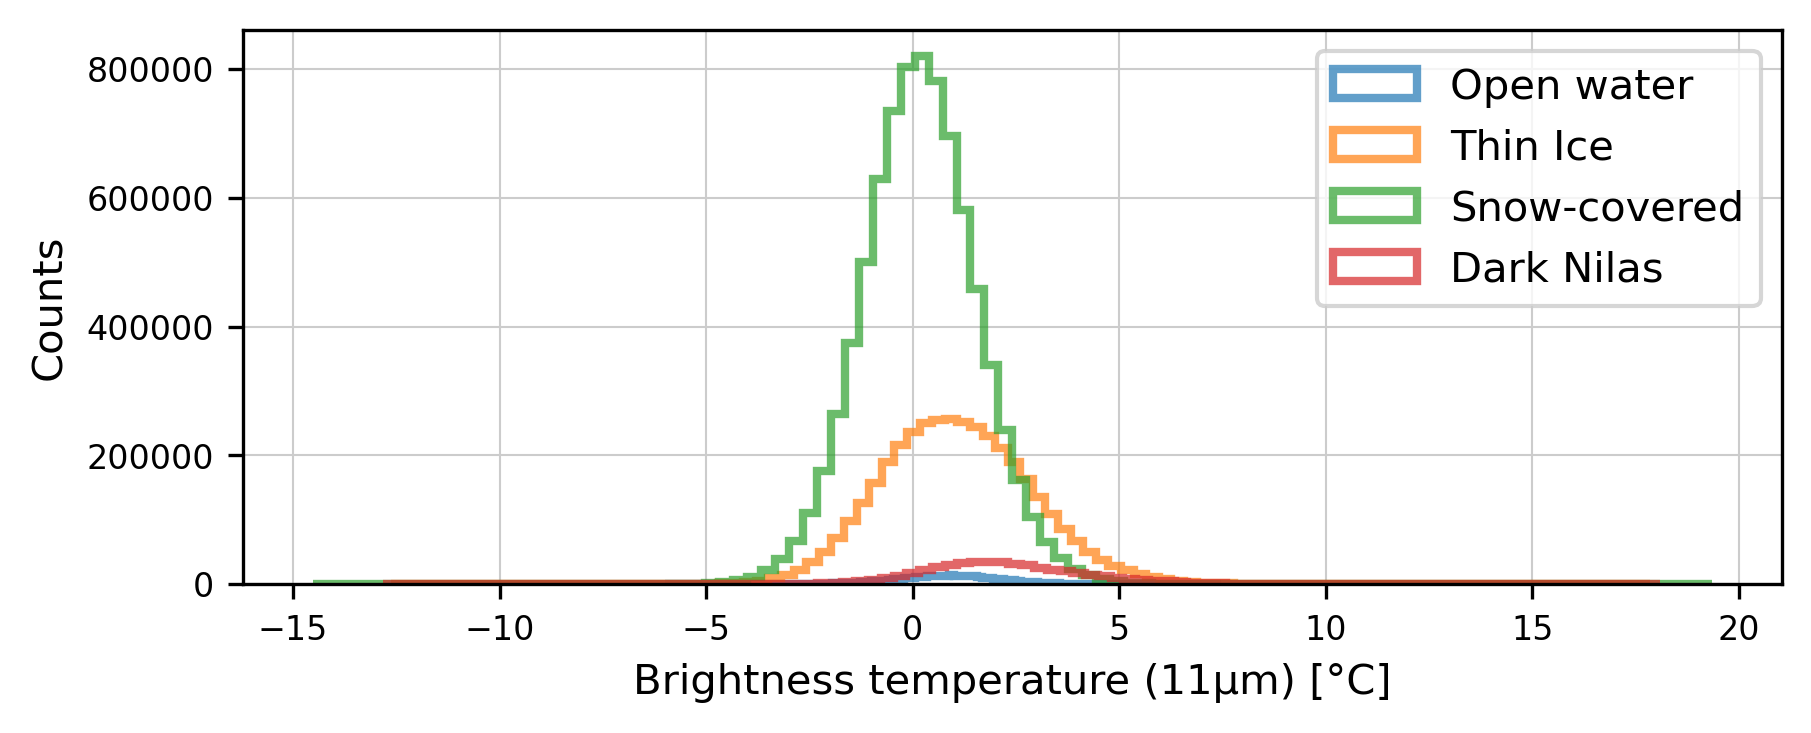

In [12]:
ds_training['X5'].where(ds_training.y_corrected == 1).plot.hist(bins=100, alpha=.7, label='Open water', histtype='step', lw=2)
ds_training['X5'].where(ds_training.y_corrected == 2).plot.hist(bins=100, alpha=.7, label='Thin Ice', histtype='step', lw=2)
ds_training['X5'].where(ds_training.y_corrected == 3).plot.hist(bins=100, alpha=.7, label='Snow-covered', histtype='step', lw=2)
ds_training['X5'].where(ds_training.y_corrected == 4).plot.hist(bins=100, alpha=.7, label='Dark Nilas', histtype='step', lw=2)
plt.legend()
plt.xlabel('Brightness temperature (11µm) [°C]')
plt.ylabel('Counts')
plt.show()

In [13]:
ds_training.to_netcdf('../../data/training_flat_corrected.nc', mode='w', engine='h5netcdf')